In [176]:
import networkx as nx #import networkx package - allows us to graph netowrks 
import polars as pl #allows us to store and use dataframes
import matplotlib.pyplot as plt #imported this in order to utilize functions of plotting one or multiple networks
import numpy as np #use math functions for things like arrays 
import random #allows us to use random functions


In [177]:
#Import all the data 
df_1 = pl.read_csv("22140-0001-Data.tsv", separator="\t") 
df_2 = pl.read_csv("22140-0002-Data.tsv", separator="\t")
df_3 = pl.read_csv("22140-0003-Data.tsv", separator="\t")

In [178]:
df_1_clean = df_1.filter(
    (pl.col("SEX").is_in([0, 1])) &                   # keep only Male/Female
    (pl.col("RACE").is_in([1, 2, 3, 4, 5])) &         # valid race codes
    (pl.col("ETHN").is_in([0, 1])) &                  # valid ethnicity codes
    (pl.col("YOB").is_between(1900, 2000))            # plausible birth years
)

df_1_clean.select([ #boolean check to ensure filtering was successful
    (pl.col("SEX").is_in([0, 1]).all()).alias("valid_SEX"),
    (pl.col("RACE").is_in([1, 2, 3, 4, 5]).all()).alias("valid_RACE"),
    (pl.col("ETHN").is_in([0, 1]).all()).alias("valid_ETHN"),
    (pl.col("YOB").is_between(1900, 2025).all()).alias("valid_YOB")
])

num_nodes = df_1_clean.select(pl.col("RID")).n_unique()
print(f"Number of nodes (unique individuals) in filtered DS001 dataset: {num_nodes}")

Number of nodes (unique individuals) in filtered DS001 dataset: 14519


In [179]:
#combine the two studies using identifiers 
node_data = df_1.filter([pl.col("STUDYNUM")== 1]) 
edge_data = df_2.filter([pl.col("STUDYNUM")== 1])

#creating the basic contact network graph 
G = nx.Graph()
G.add_nodes_from(node_data["RID"])
G.nodes
G.add_edges_from(edge_data[["ID1", "ID2"]].rows())

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100]), array([6677, 6644, 6592, 6545, 6489, 6424, 6359, 6295, 6224, 6142, 6050,
       5947, 5878, 5808, 5726, 5637, 5569, 5484, 5396, 5311, 5217, 5127,
       5041, 4954, 4881, 4811, 4746, 4678, 4606, 4548, 4492, 4425, 4347,
       4275, 4197, 4138, 4083, 3998, 3940, 3858, 3802, 3730, 3659, 3603,
       3546, 3474, 3423, 3355, 3291, 3241, 3180, 3132, 3089, 3032, 2984,
       2914, 2854, 2807, 2755, 2712, 2676, 2633, 2594, 2553, 2513, 2465

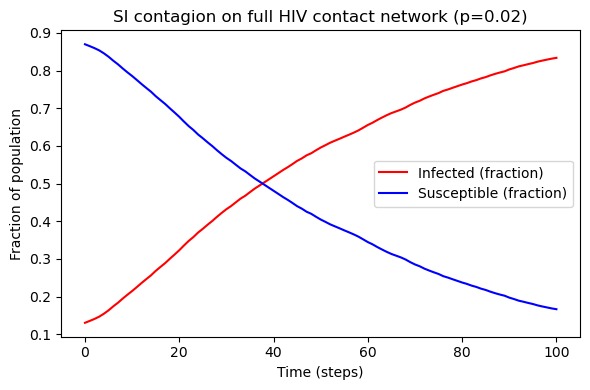

In [180]:
def SIContagion(G, initialInfected, p, tmin=0, tmax=100):
    """
    Parameters
    ----------
    G : NetworkX.Graph
    initialInfected : A set() of the nodes that are initially infected
    p : float between 0 and 1 that is the probability of infection
    tmin : integer of the initial time
    tmax : integer of the final time

    Returns
    -------
    t : numpy.array of the times
    S : numpy.array of the number of susceptible at each time
    I : numpy.array of the number of infected at each time
    """
    n = G.number_of_nodes()
    print
    infecteds = initialInfected.copy()
    newInfecteds = infecteds.copy()
    t = tmin
    times = [tmin]
    I = [len(infecteds)]
    S = [n - I[0]]

    while t < tmax:
        for node in G.nodes():
            if node not in infecteds:
                for nbr in G.neighbors(node):
                    if nbr in infecteds and random.random() <= p:
                        newInfecteds.add(node)
                        break
        t += 1
        infecteds = newInfecteds.copy()
        times.append(t)
        I.append(len(infecteds))
        S.append(n - I[-1])
    return np.array(times), np.array(S), np.array(I)
    
    
initialInfected = {i for i in random.sample(list(G.nodes), 1000)} #not sure how to choose initial infected
p = 0.02   #not sure how to choose p
print(SIContagion(G, initialInfected, p, tmin=0, tmax=100))

t, S, I = SIContagion(G, initialInfected, p, 0, 100)
print(f"Final infected fraction: {I[-1] / len(G):.3f}")

plt.figure(figsize=(6,4))
plt.plot(t, I / len(G), label="Infected (fraction)", color="red")
plt.plot(t, S / len(G), label="Susceptible (fraction)", color="blue")
plt.xlabel("Time (steps)")
plt.ylabel("Fraction of population")
plt.title(f"SI contagion on full HIV contact network (p={p})")
plt.legend()
plt.tight_layout()
plt.show()

In [181]:
yob_min = df_1.select(pl.col("YOB").min()).to_series()[0]
yob_max = df_1.select(pl.col("YOB").max()).to_series()[0]

print(f"Min YOB: {yob_min}, Max YOB: {yob_max}")

YOB = [[1900, 1910], [1911, 1920], [1921, 1930], [1931, 1940], [1941, 1950], [1951, 1960], [1961, 1970], [1971, 1980], [1981, 1990], [1991, 2000]]
"""
for yob_min, yob_max in YOB:
    df_1.filter((pl.col("YOB") >= 1900) & (pl.col("YOB") <= 1999))

sex_labels = {0: "Male", 1: "Female", -9: "OOD"}

for sex_code, label in sex_labels.items():
    subset = df_1.filter(pl.col("SEX") == sex_code)  #filtering based on sex and stored in subset 
    print(f"{label}: {subset.shape[0]} rows")
"""""
age_networks = {}

for i, (yob_min, yob_max) in enumerate(YOB):
    nodes = df_1.filter((pl.col("YOB") >= yob_min) & (pl.col("YOB") <= yob_max))
    G_yob = nx.Graph()
    G_yob.add_nodes_from(nodes["RID"])
    G_yob.add_edges_from(edge_data[["ID1", "ID2"]].rows())
    G_sub = G_yob.subgraph(nodes["RID"])

    age_networks[i] = G_sub


Min YOB: 1900, Max YOB: 1999


(array([   0,    1,    2, ...,  998,  999, 1000], shape=(1001,)), array([1775, 1773, 1772, ..., 1558, 1558, 1558], shape=(1001,)), array([1000, 1002, 1003, ..., 1217, 1217, 1217], shape=(1001,)))
Final infected fraction: 0.439


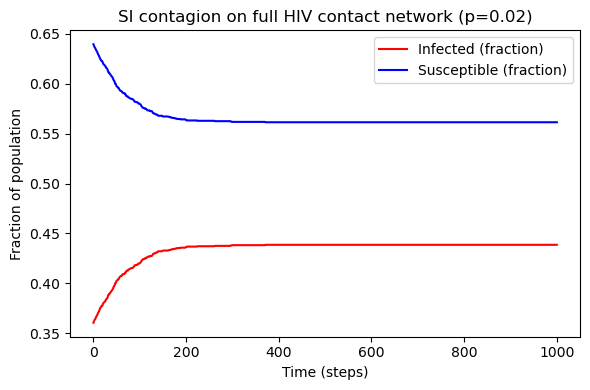

In [182]:
initialInfected = {i for i in random.sample(list(G.nodes), 1000)} #not sure how to choose initial infected
p = 0.02 
print(SIContagion(age_networks[0], initialInfected, p, tmin=0, tmax=1000))

t, S, I = SIContagion(age_networks[0], initialInfected, p, 0, 1000)
print(f"Final infected fraction: {I[-1] / len(age_networks[0]):.3f}")

plt.figure(figsize=(6,4))
plt.plot(t, I / len(age_networks[0]), label="Infected (fraction)", color="red")
plt.plot(t, S / len(age_networks[0]), label="Susceptible (fraction)", color="blue")
plt.xlabel("Time (steps)")
plt.ylabel("Fraction of population")
plt.title(f"SI contagion on full HIV contact network (p={p})")
plt.legend()
plt.tight_layout()
plt.show()

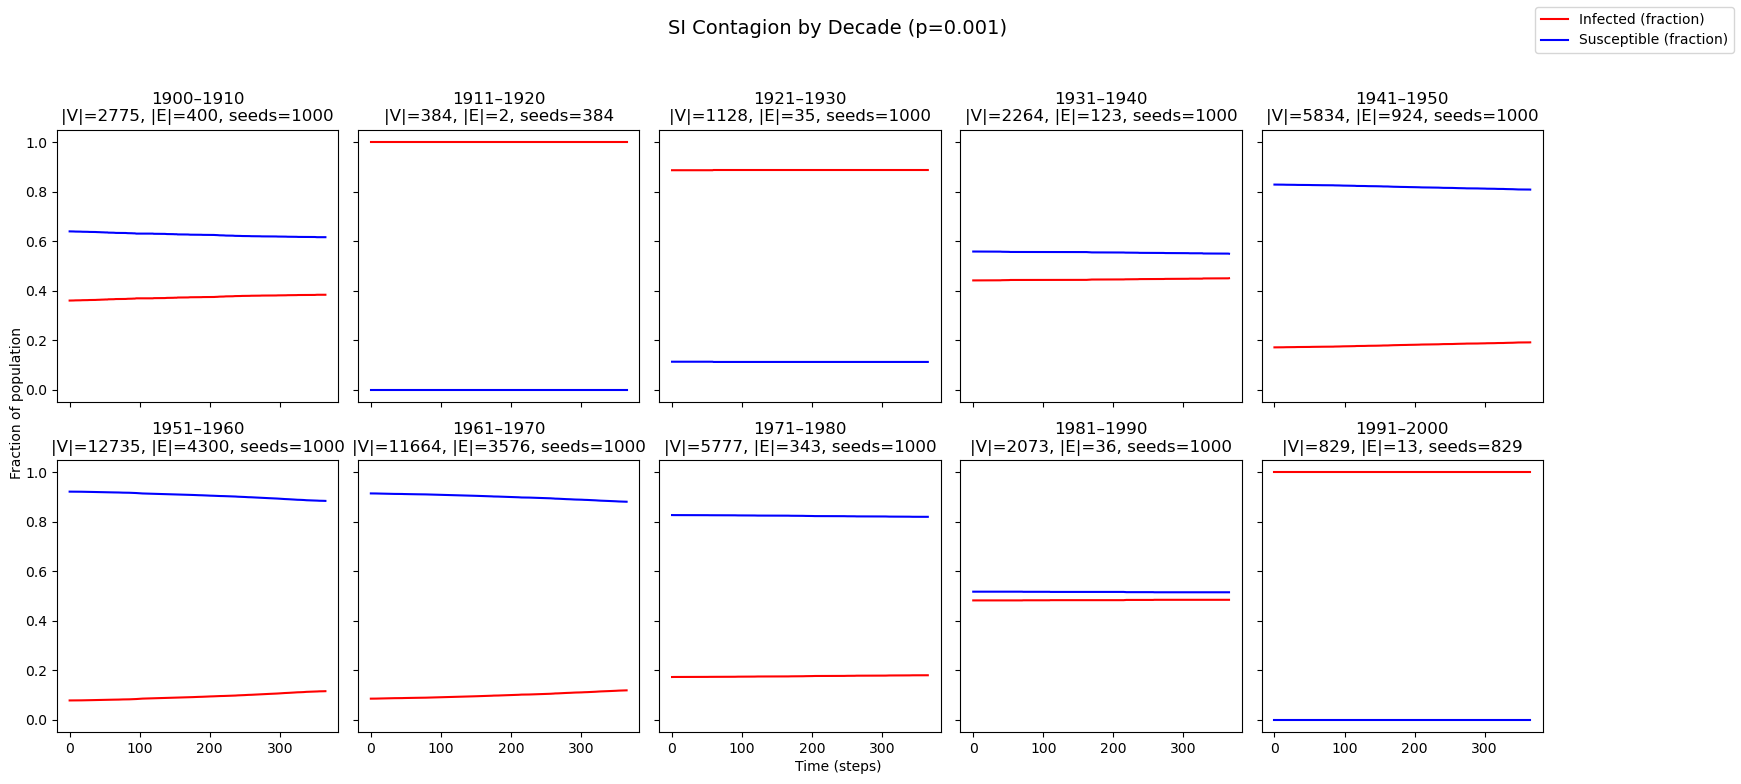

In [183]:
#values for SI simulation across decades (individual decade networks)
p = 0.001 #infection rate of HIV (Approximated from a study)
tmax = 365 #365 days in a year - looking at year long course 

# Example decade ranges (adjust these if your dict keys are numeric indices)
decade_labels = [
    "1900–1910", "1911–1920", "1921–1930", "1931–1940", "1941–1950",
    "1951–1960", "1961–1970", "1971–1980", "1981–1990", "1991–2000"
]

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (key, Gd) in enumerate(age_networks.items()):
    ax = axes[i]
    n = Gd.number_of_nodes()
    m = Gd.number_of_edges()

    if n == 0:
        ax.set_title(f"{decade_labels[i]}\nEmpty")
        ax.axis("off")
        continue

    # sample up to 1000 nodes from the subgraph
    k_seeds = min(1000, n)
    initialInfected = set(rng.sample(list(Gd.nodes()), k_seeds))

    t, S, I = SIContagion(Gd, initialInfected, p, tmin=0, tmax=tmax)

    ax.plot(t, I / n, color="red", label="Infected (fraction)")
    ax.plot(t, S / n, color="blue", label="Susceptible (fraction)")

    ax.set_title(f"{decade_labels[i]}\n|V|={n}, |E|={m}, seeds={k_seeds}")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle(f"SI Contagion by Decade (p={p})", fontsize=14)
fig.text(0.5, 0.04, "Time (steps)", ha="center")
fig.text(0.04, 0.5, "Fraction of population", va="center", rotation="vertical")
plt.tight_layout(rect=[0.04, 0.04, 0.9, 0.95])
plt.show()


In [184]:
decade_labels = [
    "1900–1910", "1911–1920", "1921–1930", "1931–1940", "1941–1950",
    "1951–1960", "1961–1970", "1971–1980", "1981–1990", "1991–2000"
]
print(f"Decade {decade_labels[1]} has {nx.number_connected_components(age_networks[1])} components")

Decade 1911–1920 has 382 components


Combined network: |V|=7677, |E|=8857


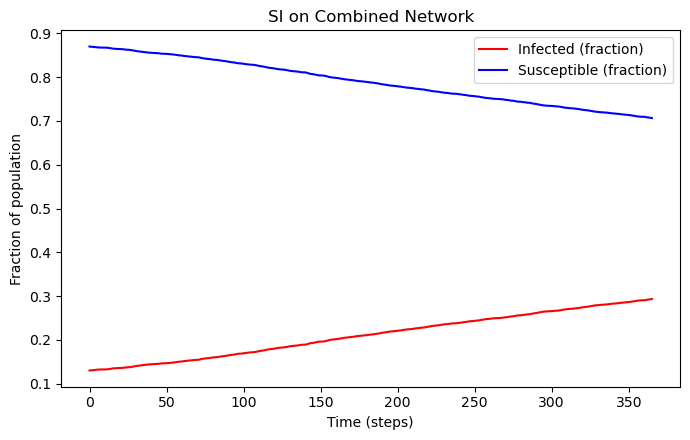

Final infected fraction: 0.294


In [185]:
# --- Combined network SI contagion with random seeding ---

# 1) Build the combined network
try:
    G_full = nx.from_pandas_edgelist(edge_data.to_pandas(), source="ID1", target="ID2")
    if "node_data" in globals():
        G_full.add_nodes_from(node_data["RID"].to_list())
except Exception:
    G_full = nx.Graph()
    for Gd in age_networks.values():
        G_full = nx.compose(G_full, Gd)

print(f"Combined network: |V|={G_full.number_of_nodes()}, |E|={G_full.number_of_edges()}")

# 2) Randomly pick initial infected nodes (no fixed seed)
if G_full.number_of_nodes() == 0:
    raise ValueError("Combined network is empty.")
giant = max(nx.connected_components(G_full), key=len)
n = len(giant)
k_seeds = min(1000, n)
initialInfected_full = set(random.sample(list(giant), k_seeds))  # random every run

# 3) Set per-contact infection probability (Boily et al., 2009)
p = 0.001
tmax = 365

# 4) Run SI contagion
t, S, I = SIContagion(G_full, initialInfected_full, p, tmin=0, tmax=tmax)

# 5) Plot results
plt.figure(figsize=(7,4.5))
plt.plot(t, I / G_full.number_of_nodes(), label="Infected (fraction)", color="red")
plt.plot(t, S / G_full.number_of_nodes(), label="Susceptible (fraction)", color="blue")
plt.xlabel("Time (steps)")
plt.ylabel("Fraction of population")
plt.title(f"SI on Combined Network")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final infected fraction: {I[-1] / G_full.number_of_nodes():.3f}")


Combined network built: |V|=35230, |E|=8857


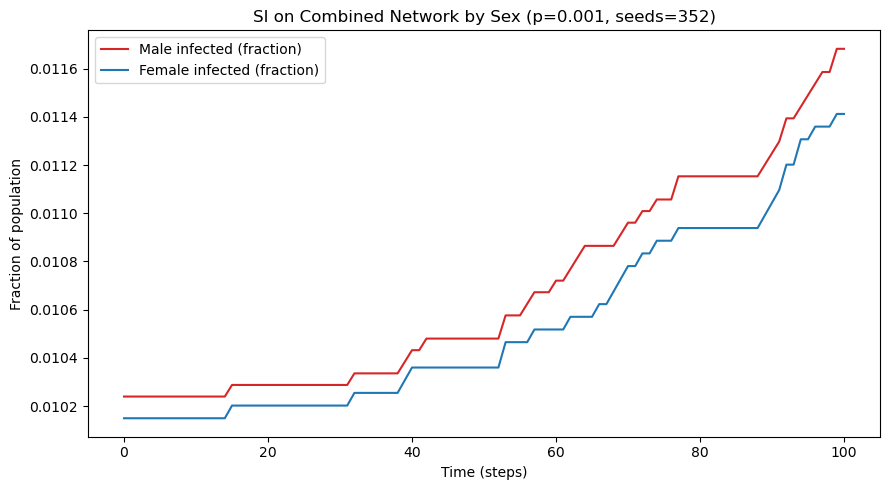

Final male infected fraction:   0.012
Final female infected fraction: 0.011


In [186]:
# --- Build the full HIV contact network ---
G_all = nx.Graph()

# Add all nodes (individuals) from df_1 using their RID
G_all.add_nodes_from(df_1.select("RID")["RID"].to_list())

# Add all edges (contacts) from edge_data
G_all.add_edges_from(edge_data[["ID1", "ID2"]].rows())

print(f"Combined network built: |V|={G_all.number_of_nodes()}, |E|={G_all.number_of_edges()}")

#Explanation: Below we just run the SI contagion tracking infected counts on the whole network but then split the results into tracking male and female infection rates. 


# node sets by sex (you already have df_1, G_all)
male_ids   = set(df_1.filter(pl.col("SEX") == 0).select("RID")["RID"].to_list())
female_ids = set(df_1.filter(pl.col("SEX") == 1).select("RID")["RID"].to_list())
n_m, n_f = len(male_ids), len(female_ids)

def SIContagion_track(G, initialInfected, p, tmin=0, tmax=100):
    n = G.number_of_nodes()
    infecteds = set(initialInfected)
    times = [tmin]
    I = [len(infecteds)]
    S = [n - I[0]]
    history = [infecteds.copy()]  # store infected set each step

    t = tmin
    while t < tmax:
        newInfecteds = infecteds.copy()
        for u in G.nodes():
            if u not in infecteds:
                for v in G.neighbors(u):
                    if v in infecteds and random.random() <= p:
                        newInfecteds.add(u)
                        break
        t += 1
        infecteds = newInfecteds
        times.append(t)
        I.append(len(infecteds))
        S.append(n - I[-1])
        history.append(infecteds.copy())
    return np.array(times), np.array(S), np.array(I), history

# --- run once on the combined graph ---
p = 0.001     # try 0.001, 0.005, 0.01 to see sensitivity
tmax = 100
n_all = G_all.number_of_nodes()
k = max(1, min(int(0.01 * n_all), n_all))  # ~1% seeding (adjust if you want)
initialInfected = set(random.sample(list(G_all.nodes()), k))

t, S, I, hist = SIContagion_track(G_all, initialInfected, p, 0, tmax)

# per-sex infected fractions over time
I_male   = np.array([len(infs & male_ids)   / n_m for infs in hist])
I_female = np.array([len(infs & female_ids) / n_f for infs in hist])

# plot
plt.figure(figsize=(9,5))
plt.plot(t, I_male,   label="Male infected (fraction)",   color="tab:red")
plt.plot(t, I_female, label="Female infected (fraction)", color="tab:blue")
plt.title(f"SI on Combined Network by Sex (p={p}, seeds={k})")
plt.xlabel("Time (steps)")
plt.ylabel("Fraction of population")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final male infected fraction:   {I_male[-1]:.3f}")
print(f"Final female infected fraction: {I_female[-1]:.3f}")


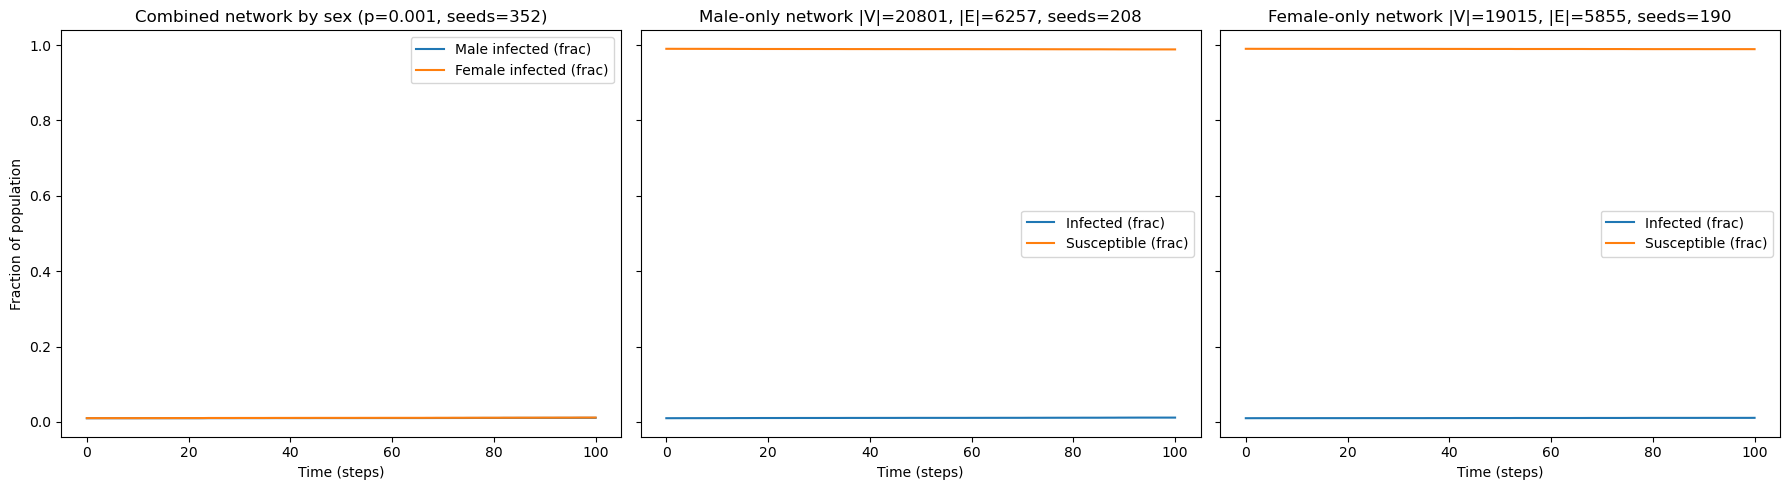

Final male infected (combined):   0.011 of males
Final female infected (combined): 0.012 of females
Final infected (male-only graph):   0.012
Final infected (female-only graph): 0.011


'\nThis result tells you:\nHeterosexual cross-sex edges are the primary bridges enabling HIV spread.\nWithin-sex links (male–male or female–female) are not dense enough to propagate infection under realistic ppp.\nThe infection probability p=0.001p = 0.001p=0.001 is too small for sustained epidemics in your network’s structure.\nIf you increase ppp (try p=0.005 or p=0.01), you should start seeing diverging male vs female curves in the left panel — that’s when gender connectivity patterns begin to matter dynamically.\n'

In [187]:
# ================= Side-by-side: Combined-by-sex vs Male-only vs Female-only =================

# --- parameters (use your existing p/tmax if set) ---
p_val   = p if 'p' in globals() else 0.001
tmax_val = tmax if 'tmax' in globals() else 100
seed_frac = 0.01  # ~1% seeds in each graph (at least 1)

# --- node sets by sex ---
male_ids   = set(df_1.filter(pl.col("SEX") == 0).select("RID")["RID"].to_list())
female_ids = set(df_1.filter(pl.col("SEX") == 1).select("RID")["RID"].to_list())
n_m, n_f = len(male_ids), len(female_ids)

# --- combined network: one SI run + track by sex ---
n_all = G_all.number_of_nodes()
k_all = max(1, min(int(seed_frac * n_all), n_all))
initial_all = set(random.sample(list(G_all.nodes()), k_all))

t_c, S_c, I_c, hist = SIContagion_track(G_all, initial_all, p_val, 0, tmax_val)
I_male_frac   = np.array([len(infs & male_ids)   / max(1, n_m) for infs in hist])
I_female_frac = np.array([len(infs & female_ids) / max(1, n_f) for infs in hist])

# --- male-only subgraph ---
G_male = G_all.subgraph(male_ids).copy()
nGm = G_male.number_of_nodes()
k_m = max(1, min(int(seed_frac * nGm), nGm)) if nGm > 0 else 0
if nGm > 0:
    init_m = set(random.sample(list(G_male.nodes()), k_m))
    t_m, S_m, I_m = SIContagion(G_male, init_m, p_val, 0, tmax_val)

# --- female-only subgraph ---
G_female = G_all.subgraph(female_ids).copy()
nGf = G_female.number_of_nodes()
k_f = max(1, min(int(seed_frac * nGf), nGf)) if nGf > 0 else 0
if nGf > 0:
    init_f = set(random.sample(list(G_female.nodes()), k_f))
    t_f, S_f, I_f = SIContagion(G_female, init_f, p_val, 0, tmax_val)

# --- figure layout ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Panel A: combined network by sex
ax = axes[0]
ax.plot(t_c, I_male_frac,   label="Male infected (frac)")
ax.plot(t_c, I_female_frac, label="Female infected (frac)")
ax.set_title(f"Combined network by sex (p={p_val}, seeds={k_all})")
ax.set_xlabel("Time (steps)")
ax.set_ylabel("Fraction of population")
ax.legend()

# Panel B: male-only network
ax = axes[1]
if nGm > 0:
    ax.plot(t_m, I_m / nGm, label="Infected (frac)")
    ax.plot(t_m, S_m / nGm, label="Susceptible (frac)")
    ax.set_title(f"Male-only network |V|={nGm}, |E|={G_male.number_of_edges()}, seeds={k_m}")
    ax.set_xlabel("Time (steps)")
    ax.legend()
else:
    ax.set_title("Male-only network: empty")
    ax.axis("off")

# Panel C: female-only network
ax = axes[2]
if nGf > 0:
    ax.plot(t_f, I_f / nGf, label="Infected (frac)")
    ax.plot(t_f, S_f / nGf, label="Susceptible (frac)")
    ax.set_title(f"Female-only network |V|={nGf}, |E|={G_female.number_of_edges()}, seeds={k_f}")
    ax.set_xlabel("Time (steps)")
    ax.legend()
else:
    ax.set_title("Female-only network: empty")
    ax.axis("off")

plt.tight_layout()
plt.show()

# --- quick summary printout ---
print(f"Final male infected (combined):   {I_male_frac[-1]:.3f} of males")
print(f"Final female infected (combined): {I_female_frac[-1]:.3f} of females")
if nGm > 0:
    print(f"Final infected (male-only graph):   {I_m[-1]/nGm:.3f}")
if nGf > 0:
    print(f"Final infected (female-only graph): {I_f[-1]/nGf:.3f}")

"""
This result tells you:
Heterosexual cross-sex edges are the primary bridges enabling HIV spread.
Within-sex links (male–male or female–female) are not dense enough to propagate infection under realistic ppp.
The infection probability p=0.001p = 0.001p=0.001 is too small for sustained epidemics in your network’s structure.
If you increase ppp (try p=0.005 or p=0.01), you should start seeing diverging male vs female curves in the left panel — that’s when gender connectivity patterns begin to matter dynamically.
"""


In [191]:
#create decades
from collections import defaultdict

nodes_in_G = set(G.nodes())
node_to_yob = {}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid in nodes_in_G:
        node_to_yob[rid] = int(row["YOB"])

decade_nodes = defaultdict(set)
for node, yob in node_to_yob.items():
    decade = (yob // 10) * 10
    decade_nodes[decade].add(node)


In [192]:
def run_age_decade_experiments_fullspread(
    G,
    decade_nodes,
    p=0.01,
    tmax=365,
    n_runs=100,
    rng_seed=42
):

    random.seed(rng_seed)
    np.random.seed(rng_seed)

    t_range = np.arange(tmax + 1)
    mean_curves = {}

    for decade, nodes in sorted(decade_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"Simulating for decade {decade}s with {len(nodes)} nodes ...")

        trajectories = []

        for _ in range(n_runs):
            # seed inside decade
            seed_node = random.choice(nodes)

            infected_over_time = SIContagion_track(
                G,
                initial_infected=[seed_node],
                p=p,
                tmax=tmax
            )

            frac = []
            node_set = set(nodes)

            for t in range(tmax + 1):
                infected = infected_over_time[t]
                frac.append(len(infected & node_set) / len(node_set))

            trajectories.append(frac)

        mean_curves[decade] = np.mean(np.array(trajectories), axis=0)

    return t_range, mean_curves


Simulating for decade 1900s with 28 nodes ...
Simulating for decade 1910s with 81 nodes ...
Simulating for decade 1920s with 157 nodes ...
Simulating for decade 1930s with 294 nodes ...
Simulating for decade 1940s with 807 nodes ...
Simulating for decade 1950s with 2475 nodes ...
Simulating for decade 1960s with 2571 nodes ...
Simulating for decade 1970s with 798 nodes ...
Simulating for decade 1980s with 331 nodes ...
Simulating for decade 1990s with 116 nodes ...


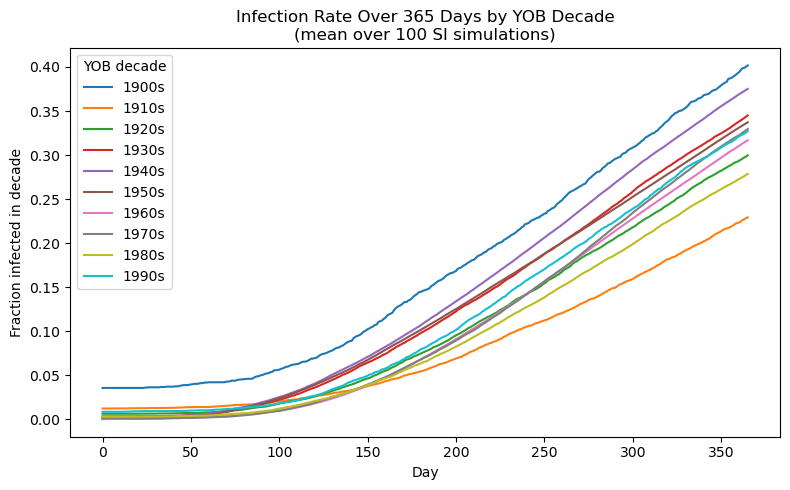

In [193]:
#plot results 
# Run the simulations (full-network spread, measure by decade)
t_range, mean_curves = run_age_decade_experiments_fullspread(
    G,
    decade_nodes,
    p=0.01,     # try 0.01–0.05 for visible dynamics
    tmax=365,   # days
    n_runs=100, # Monte Carlo runs
    rng_seed=42
)

# Plot mean infectivity by YOB decade
plt.figure(figsize=(8, 5))
for decade, curve in sorted(mean_curves.items()):
    plt.plot(t_range, curve, label=f"{decade}s")

plt.xlabel("Day")
plt.ylabel("Fraction infected in decade")
plt.title("Infection Rate Over 365 Days by YOB Decade\n(mean over 100 SI simulations)")
plt.legend(title="YOB decade")
plt.tight_layout()
plt.show()
